In [7]:
import os, zipfile
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse.linalg import svds
from scipy.sparse import hstack

ml_url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ml_zip = "ml-100k.zip"
if not os.path.exists("ml-100k"):
    urlretrieve(ml_url, ml_zip)
    with zipfile.ZipFile(ml_zip, "r") as z:
        z.extractall()

ratings_cols = ["user_id", "item_id", "rating", "timestamp"]
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=ratings_cols, encoding='latin-1')
items_cols = ["item_id", "title", "release_date", "video_release_date", "IMDb_URL"] + ["genre_"+str(i) for i in range(19)]
items = pd.read_csv("ml-100k/u.item", sep="|", names=items_cols, usecols=range(24), encoding='latin-1')
items = items[["item_id", "title"] + [c for c in items.columns if c.startswith("genre_")]]

n_users = ratings.user_id.nunique()
n_items = ratings.item_id.nunique()
R = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0).values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)
U, sigma, Vt = svds(R_demeaned, k=50)
sigma = np.diag(sigma)
pred_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
cf_preds_df = pd.DataFrame(pred_ratings, index=np.arange(1, n_users+1), columns=np.arange(1, n_items+1))

genre_cols = [c for c in items.columns if c.startswith("genre_")]
genre_matrix = items[genre_cols].astype(float).values
tfidf = TfidfVectorizer(stop_words='english')
title_tfidf = tfidf.fit_transform(items['title'].fillna(''))
content_features = hstack([genre_matrix, title_tfidf])
item_sim = cosine_similarity(content_features)

item_id_to_idx = {iid: idx for idx, iid in enumerate(items['item_id'])}
idx_to_item_id = {idx: iid for iid, idx in item_id_to_idx.items()}

def hybrid_recommend(user_id, alpha=0.7, N=10):
    cf_scores = cf_preds_df.loc[user_id].to_dict()
    scaler = MinMaxScaler()
    cf_norm = dict(zip(cf_scores.keys(), scaler.fit_transform(np.array(list(cf_scores.values())).reshape(-1,1)).flatten()))
    rated_items = ratings[(ratings.user_id==user_id) & (ratings.rating>=4)].item_id.values
    if len(rated_items) > 0:
        rated_idxs = [item_id_to_idx[iid] for iid in rated_items if iid in item_id_to_idx]
        content_scores = item_sim[rated_idxs].mean(axis=0)
        content_norm = dict(zip(items.item_id, scaler.fit_transform(content_scores.reshape(-1,1)).flatten()))
    else:
        content_norm = {iid:0 for iid in items.item_id}
    hybrid = {iid: alpha*cf_norm.get(iid,0) + (1-alpha)*content_norm.get(iid,0) for iid in items.item_id}
    rated = set(ratings[ratings.user_id==user_id].item_id.values)
    hybrid = {iid:score for iid,score in hybrid.items() if iid not in rated}
    topN = sorted(hybrid.items(), key=lambda x: x[1], reverse=True)[:N]
    return [(iid, items.loc[items.item_id==iid,'title'].values[0], score) for iid,score in topN]

for iid, title, score in hybrid_recommend(1, alpha=0.7, N=10):
    print(f"{iid:5d} | {score:.4f} | {title}")


  403 | 0.6137 | Batman (1989)
  423 | 0.5957 | E.T. the Extra-Terrestrial (1982)
  382 | 0.5862 | Adventures of Priscilla, Queen of the Desert, The (1994)
  778 | 0.5700 | Don Juan DeMarco (1995)
  357 | 0.5651 | One Flew Over the Cuckoo's Nest (1975)
  582 | 0.5622 | Piano, The (1993)
  303 | 0.5536 | Ulee's Gold (1997)
  276 | 0.5493 | Leaving Las Vegas (1995)
  385 | 0.5491 | True Lies (1994)
  936 | 0.5469 | Brassed Off (1996)


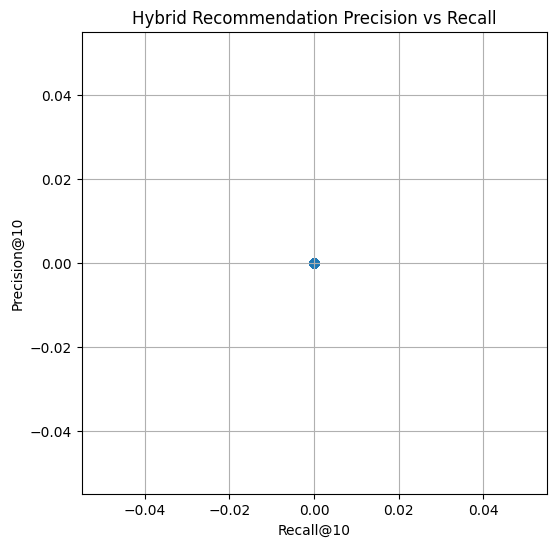

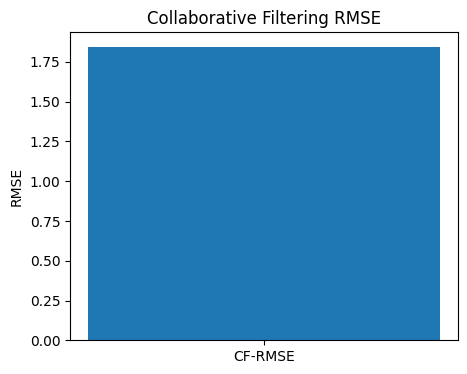

In [8]:
import matplotlib.pyplot as plt

def precision_recall_at_k(user_id, k=10, alpha=0.7, threshold=4):
    true_items = ratings[(ratings.user_id == user_id) & (ratings.rating >= threshold)].item_id.tolist()
    if not true_items:
        return 0, 0
    rec_items = [iid for iid, _, _ in hybrid_recommend(user_id, alpha=alpha, N=k)]
    hits = len(set(true_items) & set(rec_items))
    precision = hits / k
    recall = hits / len(true_items)
    return precision, recall

precisions, recalls = [], []
for u in ratings.user_id.unique()[:200]:
    p, r = precision_recall_at_k(u, k=10, alpha=0.7)
    precisions.append(p)
    recalls.append(r)

plt.figure(figsize=(6,6))
plt.scatter(recalls, precisions, alpha=0.6)
plt.xlabel("Recall@10")
plt.ylabel("Precision@10")
plt.title("Hybrid Recommendation Precision vs Recall")
plt.grid(True)
plt.show()

from sklearn.metrics import mean_squared_error
from math import sqrt

test_ratings = ratings.sample(frac=0.2, random_state=42)
y_true = test_ratings['rating'].values
y_pred = [cf_preds_df.loc[u, i] for u, i in zip(test_ratings['user_id'], test_ratings['item_id'])]
rmse = sqrt(mean_squared_error(y_true, y_pred))

plt.figure(figsize=(5,4))
plt.bar(["CF-RMSE"], [rmse])
plt.ylabel("RMSE")
plt.title("Collaborative Filtering RMSE")
plt.show()
